# Neural POS Tagging
In this notebook, we will use the `AnnPosTagger` and `LstmPosTagger` classes for POS Tagging. The source code for these classes can be found inside `pos_tagging/models/PosTagger.py`. 

For implementation details, please refer to the README of this repository.

# Import Modules

In [1]:
import numpy as np
import pickle
import importlib
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

from pos_tagging.tag_datasets import TagData # loading and preprocessing
from pos_tagging.models import PosTagger # contains AnnPosTagger class

# reload modules in case of changes to the files
importlib.reload(TagData)
importlib.reload(PosTagger)

TagDataset = TagData.TagDataset

# Load Data

In [2]:
trainData = TagDataset('./data/UD_English-Atis/en_atis-ud-train.conllu')
print("Vocabulary size:", len(trainData.vocabulary))
print("Number of Classes", len(trainData.classes))
devData = TagDataset('./data/UD_English-Atis/en_atis-ud-dev.conllu')
testData = TagDataset('./data/UD_English-Atis/en_atis-ud-test.conllu')

Vocabulary size: 865
Number of Classes 13


# Training the Model
## ANN

In [3]:
annTagger = PosTagger.AnnPosTagger(trainData, 
                                   devData, 
                                   futureContextSize=2,
                                   pastContextSize=2,
                                   activation='sigmoid', 
                                   embeddingSize=128,
                                   hiddenLayers=[64],
                                   batchSize=128)
annTagger.train(epochs=20, learningRate=1e-3, verbose=True, retrain=True)

/home/ashmitchamoli/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1: train loss = 1.926, dev loss = 1.7907, dev accuracy = 0.9166
Epoch 2: train loss = 1.7677, dev loss = 1.7475, dev accuracy = 0.9511
Epoch 3: train loss = 1.7384, dev loss = 1.7301, dev accuracy = 0.9648
Epoch 4: train loss = 1.7244, dev loss = 1.7231, dev accuracy = 0.9705
Epoch 5: train loss = 1.7183, dev loss = 1.7191, dev accuracy = 0.9728
Epoch 6: train loss = 1.7147, dev loss = 1.7165, dev accuracy = 0.9755
Epoch 7: train loss = 1.7118, dev loss = 1.7151, dev accuracy = 0.9767
Epoch 8: train loss = 1.7095, dev loss = 1.7132, dev accuracy = 0.9777
Epoch 9: train loss = 1.7077, dev loss = 1.7117, dev accuracy = 0.9797
Epoch 10: train loss = 1.7061, dev loss = 1.71, dev accuracy = 0.9809
Epoch 11: train loss = 1.705, dev loss = 1.7095, dev accuracy = 0.9806
Epoch 12: train loss = 1.7041, dev loss = 1.7091, dev accuracy = 0.9804
Epoch 13: train loss = 1.7033, dev loss = 1.708, dev accuracy = 0.9824
Epoch 14: train loss = 1.7027, dev loss = 1.7077, dev accuracy = 0.9825
Epoch 

Let us visualize the training loss, dev loss, and dev accuracy for each epoch.

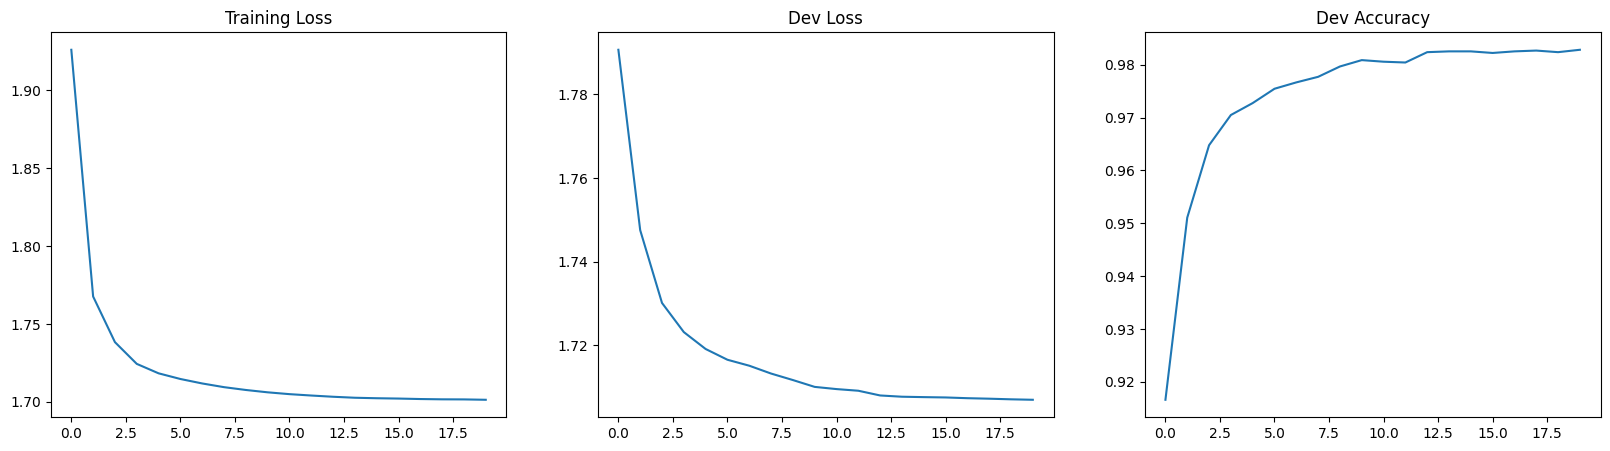

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(annTagger.trainLoss)
ax[1].plot(annTagger.devLoss)
ax[2].plot(annTagger.devAccuracy)
ax[0].set_title('Training Loss')
ax[1].set_title('Dev Loss')
ax[2].set_title('Dev Accuracy')
plt.show()


## RNN

In [5]:
lstmTagger = PosTagger.LstmPosTagger(trainData,
                                     devData,
                                     activation='tanh',
                                     embeddingSize=128,
                                     batchSize=1,
                                     hiddenSize=128,
                                     numLayers=3,
                                     bidirectional=True,
                                     linearHiddenLayers=[64])
lstmTagger.train(epochs=10, learningRate=1e-3, verbose=True, retrain=True)

Epoch 1 | Train Loss: 2.140 | Dev Accuracy: 0.848
Epoch 2 | Train Loss: 2.105 | Dev Accuracy: 0.908
Epoch 3 | Train Loss: 2.102 | Dev Accuracy: 0.932
Epoch 4 | Train Loss: 2.100 | Dev Accuracy: 0.949
Epoch 5 | Train Loss: 2.100 | Dev Accuracy: 0.952
Epoch 6 | Train Loss: 2.099 | Dev Accuracy: 0.959
Epoch 7 | Train Loss: 2.099 | Dev Accuracy: 0.960
Epoch 8 | Train Loss: 2.099 | Dev Accuracy: 0.961
Epoch 9 | Train Loss: 2.099 | Dev Accuracy: 0.959
Epoch 10 | Train Loss: 2.099 | Dev Accuracy: 0.961


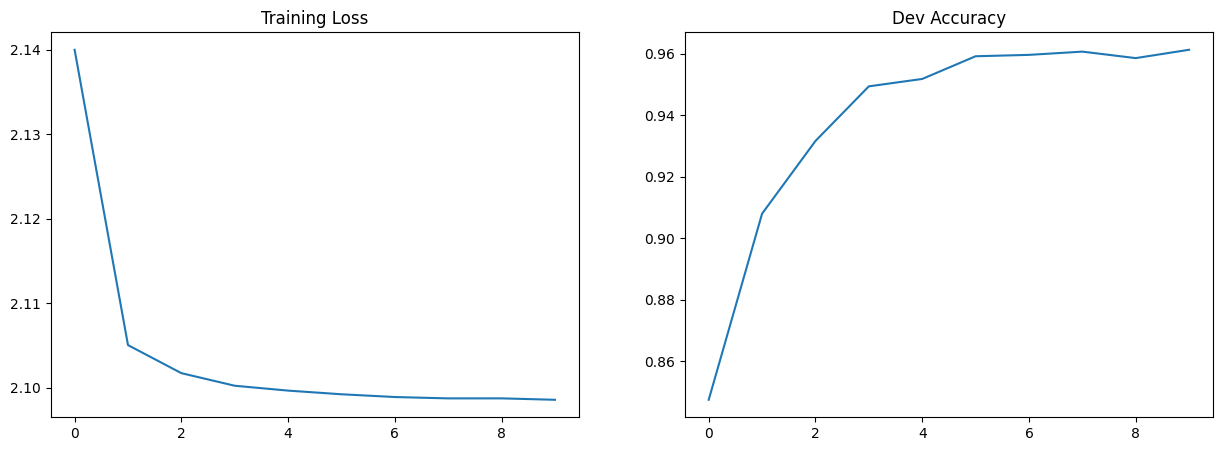

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(lstmTagger.trainLoss)
ax[1].plot(lstmTagger.devAccuracy)
ax[0].set_title('Training Loss')
ax[1].set_title('Dev Accuracy')
plt.show()

# Evalutation
## ANN Tagger
Let us test the model on a random sentence from the test set.

In [7]:
testData = TagDataset('./data/UD_English-Atis/en_atis-ud-test.conllu')
i = np.random.randint(0, len(testData.dataset))

sentence = [ word[1] for word in testData.dataset[i] ]
preds = annTagger.predict(sentence)

print(tabulate([['Sentence'] + sentence, 
                ['Predicted Tags'] + preds, 
                ['Actual Tags'] + [word[2] for word in testData.dataset[i]]], 
                tablefmt="fancy_grid"))

╒════════════════╤═════╤════════╤══════╤═══════════╤══════╤════════╕
│ Sentence       │ the │ flight │ will │ originate │ from │ boston │
├────────────────┼─────┼────────┼──────┼───────────┼──────┼────────┤
│ Predicted Tags │ DET │ NOUN   │ AUX  │ NOUN      │ ADP  │ PROPN  │
├────────────────┼─────┼────────┼──────┼───────────┼──────┼────────┤
│ Actual Tags    │ DET │ NOUN   │ AUX  │ VERB      │ ADP  │ PROPN  │
╘════════════════╧═════╧════════╧══════╧═══════════╧══════╧════════╛


Let us view the classification report and the confusion matrix for the model.

              precision    recall  f1-score   support

         ADJ       0.92      0.96      0.94       220
         ADP       1.00      1.00      1.00      1434
         ADV       0.98      0.66      0.79        76
         AUX       0.99      0.99      0.99       256
       CCONJ       1.00      1.00      1.00       109
         DET       0.99      0.99      0.99       512
        INTJ       0.97      1.00      0.99        36
        NOUN       0.97      0.99      0.98      1166
         NUM       0.96      0.89      0.92       127
        PART       0.92      0.98      0.95        56
        PRON       0.99      0.99      0.99       392
       PROPN       0.99      0.99      0.99      1567
        VERB       0.99      0.98      0.99       629

    accuracy                           0.99      6580
   macro avg       0.98      0.96      0.96      6580
weighted avg       0.99      0.99      0.98      6580



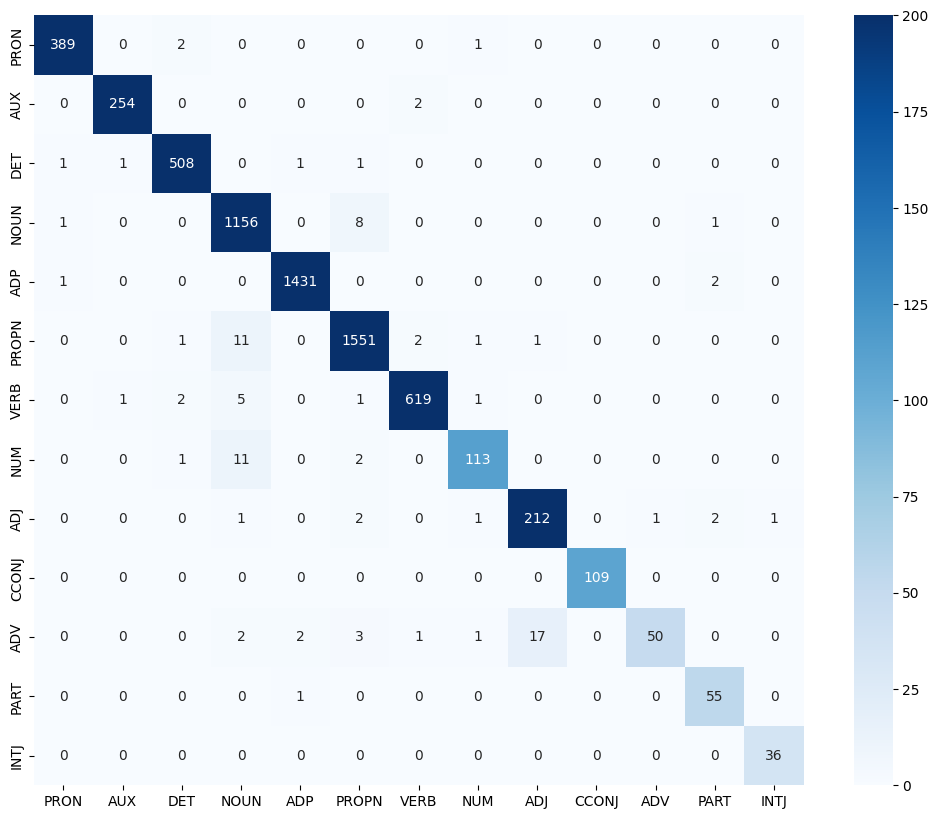

In [8]:
annTagger.evaluateModel(testData)
print(annTagger.classificationReport)

plt.figure(figsize=(13, 10))
sns.heatmap(annTagger.confusionMatrix, annot=True, square=True, fmt='d', cmap='Blues', vmax=200, xticklabels=lstmTagger.classes, yticklabels=lstmTagger.classes)
plt.show()

We can see that the model is sometimes predicts DET as a PRON but otherwise the performance is satisfactory.

## RNN Tagger

In [9]:
testData = TagDataset('./data/UD_English-Atis/en_atis-ud-test.conllu')
i = np.random.randint(0, len(testData.dataset))

sentence = [ word[1] for word in testData.dataset[i] ]
preds = lstmTagger.predict(sentence)

print(tabulate([['Sentence'] + sentence, 
                ['Predicted Tags'] + preds, 
                ['Actual Tags'] + [word[2] for word in testData.dataset[i]]], 
                tablefmt="fancy_grid"))

╒════════════════╤══════════╤═══════╤════════╤═════════╤═════════╤═══════════╤═══════╤═════════╤══════════╤══════════╕
│ Sentence       │ saturday │ or    │ sunday │ flights │ between │ milwaukee │ and   │ phoenix │ american │ airlines │
├────────────────┼──────────┼───────┼────────┼─────────┼─────────┼───────────┼───────┼─────────┼──────────┼──────────┤
│ Predicted Tags │ NOUN     │ CCONJ │ NOUN   │ NOUN    │ ADP     │ PROPN     │ CCONJ │ PROPN   │ PROPN    │ PROPN    │
├────────────────┼──────────┼───────┼────────┼─────────┼─────────┼───────────┼───────┼─────────┼──────────┼──────────┤
│ Actual Tags    │ NOUN     │ CCONJ │ NOUN   │ NOUN    │ ADP     │ PROPN     │ CCONJ │ PROPN   │ PROPN    │ PROPN    │
╘════════════════╧══════════╧═══════╧════════╧═════════╧═════════╧═══════════╧═══════╧═════════╧══════════╧══════════╛


              precision    recall  f1-score   support

         ADJ       0.75      0.95      0.84       220
         ADP       1.00      0.96      0.98      1434
         ADV       0.50      0.68      0.57        76
         AUX       0.89      0.98      0.93       256
       CCONJ       0.79      0.98      0.88       109
         DET       0.98      0.97      0.97       512
        INTJ       0.64      1.00      0.78        36
        NOUN       1.00      0.97      0.98      1166
         NUM       0.87      0.85      0.86       127
        PART       0.79      1.00      0.88        56
        PRON       0.95      0.98      0.97       392
       PROPN       1.00      0.98      0.99      1567
        VERB       0.98      0.88      0.93       629

    accuracy                           0.96      6580
   macro avg       0.86      0.94      0.89      6580
weighted avg       0.97      0.96      0.96      6580



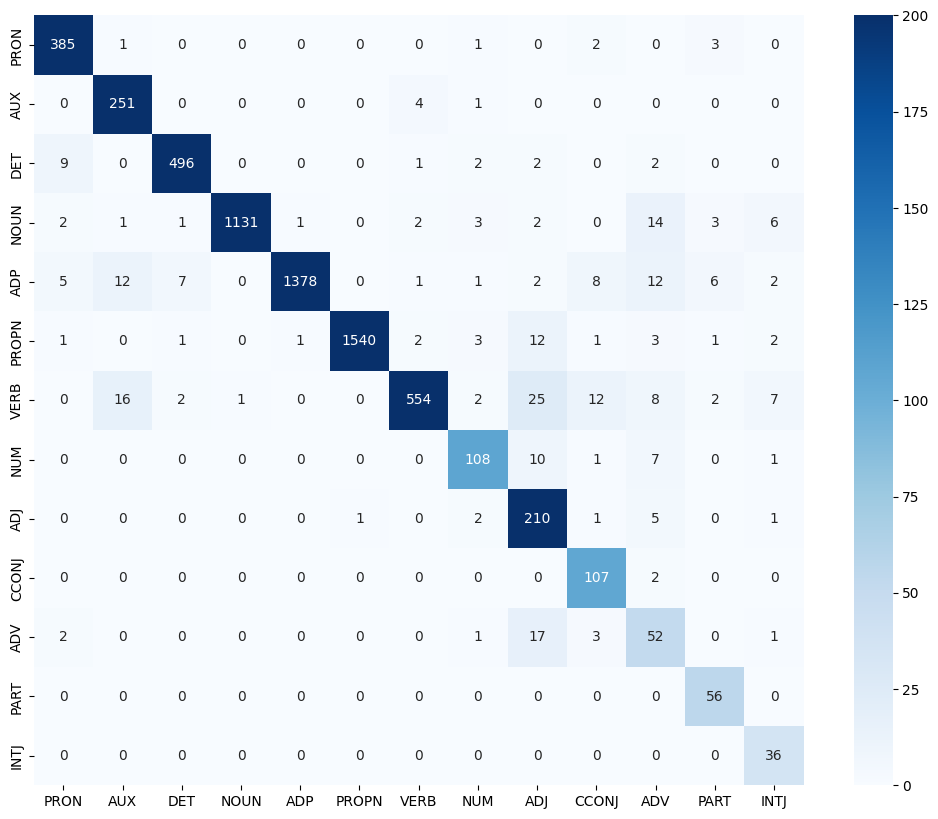

In [11]:
lstmTagger.evaluateModel(testData)
print(lstmTagger.classificationReport)

plt.figure(figsize=(13, 10))
sns.heatmap(lstmTagger.confusionMatrix, annot=True, square=True, fmt='d', cmap='Blues', vmax=200, xticklabels=lstmTagger.classes, yticklabels=lstmTagger.classes)
plt.show()

# Hyperparameter Tuning
## ANN Tagger

We will use a grid search on the hyperparameters to find the best model.

In [ ]:
# hiddenLayerss = [ [], [16], [32], [64], [16, 16], [32, 16] ]
# embeddingSizes = [ 64, 128, 256 ]
# activations = [ 'relu', 'sigmoid', 'tanh' ]
# contextSizes = [ 0, 1, 2, 3, 4 ]
# epochss = [ 15, 30, 45 ]
# lrs = [ 1e-1, 1e-2, 1e-3 ]
# modelScores = {}

# for hiddenlayers in hiddenLayerss:
#     for embeddingSize in embeddingSizes:
#         for activation in activations:
#             for contextSize in contextSizes:
#                 for epochs in epochss:
#                     for lr in lrs:
#                         posTagger = PosTagger.AnnPosTagger(trainData,
#                                                            devData,
#                                                            contextSize=contextSize,
#                                                            activation=activation,
#                                                            embeddingSize=embeddingSize,
#                                                            hiddenLayers=hiddenlayers,
#                                                            batchSize=128)
#                         posTagger.train(epochs=epochs, learningRate=lr)
#                         key = str( [hiddenlayers, embeddingSize, activation, contextSize, epochs, lr] )
#                         modelScores[key] = {}
#                         modelScores[key]['dev'] = posTagger.evaluateModel(devData)
#                         modelScores[key]['train'] = posTagger.evaluateModel(trainData)
#                         modelScores[key]['test'] = posTagger.evaluateModel(testData)
#                         # save the modelScores dictionary to a file
#                         with open('model_scores.pkl', 'wb') as file:
#                             pickle.dump(data/modelScores, file)

In [ ]:
# top 10 models
modelScores = pickle.load(open('data/model_scores.pkl', 'rb'))

k = 3
topkModels = sorted(modelScores.items(), key=lambda x: x[1]['dev']['f1'], reverse=True)[:3]

print(f"Dev set scores for the top {k} models:\n")
print(tabulate( [  [ item.strip('[]') for item in  model[0].split(', ') ] + list(model[1]['dev'].values()) for model in topkModels ], 
               headers=['Hidden Layers', 'Embedding Size', 'Activation', 'Context Size', 'Epochs', 'Learning Rate', 'Dev Accuracy', 'Dev Precision', 'Dev Recall', 'Dev F1'] ) )

print(f"\nTest set scores for the best performing model on the dev set:\n")
print(tabulate( [  [ item.strip('[]') for item in  model[0].split(', ') ] + list(model[1]['test'].values()) for model in topkModels[:1] ], 
               headers=['Hidden Layers', 'Embedding Size', 'Activation', 'Context Size', 'Epochs', 'Learning Rate', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1'] ) )

Dev set scores for the top 3 models:

  Hidden Layers    Embedding Size  Activation      Context Size    Epochs    Learning Rate    Dev Accuracy    Dev Precision    Dev Recall    Dev F1
---------------  ----------------  ------------  --------------  --------  ---------------  --------------  ---------------  ------------  --------
             64               128  'sigmoid'                  1        45            0.001        0.984798         0.984565      0.984798  0.984525
             32               128  'sigmoid'                  2        45            0.001        0.984046         0.983814      0.984046  0.983802
             64               256  'relu'                     2        45            0.001        0.983745         0.983507      0.983745  0.983487

Test set scores for the best performing model on the dev set:

  Hidden Layers    Embedding Size  Activation      Context Size    Epochs    Learning Rate    Test Accuracy    Test Precision    Test Recall    Test F1
------

Let us plot Dev accuracy vs context window size for the best performing model.

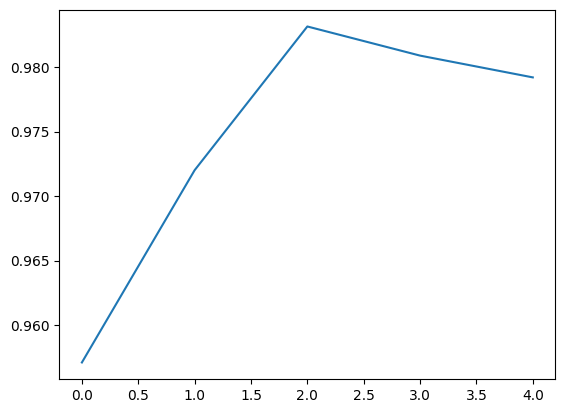

In [ ]:
def trainBestModel(contextSize : int) -> None:
    posTagger = PosTagger.AnnPosTagger(trainData,
                                       devData,
                                       futureContextSize=contextSize,
                                       pastContextSize=contextSize,
                                       activation='sigmoid',
                                       embeddingSize=128,
                                       hiddenLayers=[64],
                                       batchSize=128)
    posTagger.train(epochs=30, learningRate=1e-3)
    posTagger.evaluateModel(devData)
    return posTagger

model0 = trainBestModel(0)
model1 = trainBestModel(1)
model2 = trainBestModel(2)
model3 = trainBestModel(3)
model4 = trainBestModel(4)

plt.plot([ 0, 1, 2, 3, 4 ], [ model0.scores['accuracy'], model1.scores['accuracy'], model2.scores['accuracy'], model3.scores['accuracy'], model4.scores['f1'] ])
plt.show()

We can see that the accuracy is the best for contextSize = 2.

## RNN Tagger


In [22]:
embeddingSizes = 128, 256
lr = 1e-3
hiddenSizes = 64, 128
hiddenLayerss = [64], [32, 16], [64, 32]
epochs = 30
activation = 'relu'
numLayerss = 1, 2, 3
lstmModelScores = {}

for hiddenSize in hiddenSizes:
    for hiddenLayers in hiddenLayerss:
        for numLayers in numLayerss:
            for embeddingSize in embeddingSizes:
                lstmTagger = PosTagger.LstmPosTagger(trainData,
                                                    devData,
                                                    activation=activation,
                                                    embeddingSize=embeddingSize,
                                                    hiddenSize=hiddenSize,
                                                    linearHiddenLayers=hiddenLayers,
                                                    batchSize=1,
                                                    bidirectional=True,
                                                    numLayers=numLayers)
                lstmTagger.train(epochs=epochs, learningRate=lr)
                lstmTagger.evaluateModel(devData)
                key = str([hiddenLayers, embeddingSize, hiddenSize, numLayers, activation, epochs, lr])
                lstmModelScores[key] = {}
                lstmModelScores[key]['dev'] = lstmTagger.evaluateModel(devData)
                lstmModelScores[key]['train'] = lstmTagger.evaluateModel(trainData)
                lstmModelScores[key]['test'] = lstmTagger.evaluateModel(testData)

                # save the lstmModelScores dictionary to a file
                with open('data/lstm_model_scores_.pkl', 'wb') as file:
                    pickle.dump(lstmModelScores, file)

In [ ]:
# top 10 models
lstmModelScores = pickle.load(open('data/lstm_model_scores.pkl', 'rb'))

k = 3
topkModels = sorted(lstmModelScores.items(), key=lambda x: x[1]['dev']['f1'], reverse=True)[:3]

print(f"Dev set scores for the top {k} models:\n")
print(tabulate( [ [model[0]] + list(model[1]['dev'].values()) for model in topkModels ],
               headers=['Model Parameters', 'Dev Accuracy', 'Dev Precision', 'Dev Recall', 'Dev F1'] ) )

print(f"\nTest set scores for the best performing model on the dev set:\n")
print(tabulate( [ [ model[0] ] + list(model[1]['test'].values()) for model in topkModels[:1] ], 
               headers=['Model Parameters', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1'] ) )

Dev set scores for the top 3 models:

Model Parameters                  Dev Accuracy    Dev Precision    Dev Recall    Dev F1
------------------------------  --------------  ---------------  ------------  --------
[[64], 256, 'relu', 30, 0.001]        0.957556         0.965117      0.957556  0.959561

Test set scores for the best performing model on the dev set:

Model Parameters                  Test Accuracy    Test Precision    Test Recall    Test F1
------------------------------  ---------------  ----------------  -------------  ---------
[[64], 256, 'relu', 30, 0.001]         0.956535          0.963242       0.956535    0.95831


Epoch vs. Dev Accuracy graph for the 3 best models, based on dev set scores.

In [ ]:
lstmModel1 = PosTagger.LstmPosTagger(trainData, devData, activation='relu', embeddingSize=128, hiddenSize=128, linearHiddenLayers=[64, 32], batchSize=1, bidirectional=True)
lstmModel1.train(epochs=30, learningRate=1e-3)

lstmModel2 = PosTagger.LstmPosTagger(trainData, devData, activation='relu', embeddingSize=128, hiddenSize=128, linearHiddenLayers=[32, 16], batchSize=1, bidirectional=True)
lstmModel2.train(epochs=30, learningRate=1e-3)

lstmModel3 = PosTagger.LstmPosTagger(trainData, devData, activation='relu', embeddingSize=128, hiddenSize=128, linearHiddenLayers=[64], batchSize=1, bidirectional=True)
lstmModel3.train(epochs=30, learningRate=1e-3)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(lstmModel1.devAccuracy)
ax[1].plot(lstmModel2.devAccuracy)
ax[2].plot(lstmModel3.devAccuracy)
ax[0].set_title('Training Loss')
ax[1].set_title('Dev Loss')
ax[2].set_title('Dev Accuracy')
plt.show()